![Banner](https://github.com/LittleHouse75/flatiron-resources/raw/main/NevitsBanner.png)
---
# Experiment 3 — Frontier LLMs via OpenRouter
### Zero-Shot Dialogue Summarization Using API Models
---

This notebook evaluates **frontier large language models** (OpenAI, Anthropic, Google, Mistral, etc.)  
via **OpenRouter**, using a *single* API interface.

We:
- Load the SAMSum dataset (test or validation set, configurable)
- Sample N examples (or use all, configurable)
- Send them to multiple frontier models  
- Score ROUGE  
- Save predictions + latencies  
- Produce qualitative examples  

This establishes the **upper-bound performance baseline** for the project.

In [55]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Environment Setup

In [56]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

from pathlib import Path
import sys
import numpy as np
import pandas as pd
import json
import hashlib

PROJECT_ROOT = Path("..").resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from src.utils.openrouter_client import ERROR_PREFIX



## 2. Configuration

**Important:** Set `RUN_API_CALLS` to `False` to load cached results instead of 
making new API calls. This saves money and time when you just want to analyze
previous results.

You can also control individual models with the `MODELS_TO_RUN` dictionary.

In [57]:
# =============================================================================
# API CALL FLAGS - Set these to control what runs
# =============================================================================

# Master switch: Set False to load ALL results from cache (no API calls)
RUN_API_CALLS = True

# Per-model control: Set individual models to False to skip them
# Only matters if RUN_API_CALLS = True
MODELS_TO_RUN = {
    "gpt5_nano":        True,
    "gpt5_mini":        True,
    "gpt5_full":        True,
    "gpt_oss_20b":      True,
    "gpt_oss_120b":     True,
    "gemini_25_flash":  True,
    "claude_45_sonnet": True,
    "qwen25_72b":       True,
}

# =============================================================================
# EXPERIMENT PARAMETERS
# =============================================================================

# EVALUATION MODE:
# - "test": Use a small sample (fast, cheap) for debugging/development
# - "full": Use all examples (slow, expensive) for final results
EVALUATION_MODE = "test"  # Change to "full" when ready for final run

# How many samples to use in "test" mode (ignored in "full" mode)
TEST_MODE_SAMPLES = 100

SEED = 42
MAX_OUT_TOKENS = 512  # Max tokens for model responses

# =============================================================================
# WHICH DATASET SPLIT TO USE
# =============================================================================
USE_TEST_SET = True   # True = test set (for final comparison)
                      # False = validation set (for development/debugging)

# =============================================================================
# PATHS
# =============================================================================
RESULTS_DIR = PROJECT_ROOT / "experiments" / "exp3_api_llm_results"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

ROUGE_SUMMARY_PATH = RESULTS_DIR / "rouge_summary.csv"
LATENCY_SUMMARY_PATH = RESULTS_DIR / "latency_summary.csv"

# =============================================================================
# MODEL DEFINITIONS
# =============================================================================
OPENROUTER_MODELS = {
    # OpenAI family – small → big
    "gpt5_nano":       "openai/gpt-5-nano",
    "gpt5_mini":       "openai/gpt-5-mini",
    "gpt5_full":       "openai/gpt-5",          # flagship upper bound

    # OpenAI open-weight models
    "gpt_oss_20b":     "openai/gpt-oss-20b",
    "gpt_oss_120b":    "openai/gpt-oss-120b",

    # Google Gemini – fast, very strong general model
    "gemini_25_flash": "google/gemini-2.5-flash",

    # Anthropic Claude – strong competitor
    "claude_45_sonnet": "anthropic/claude-4.5-sonnet-20250929",

    # Qwen – top-tier open(-ish) model
    "qwen25_72b":      "qwen/qwen-2.5-72b-instruct",
}

print(f"Results directory: {RESULTS_DIR}")
print(f"RUN_API_CALLS: {RUN_API_CALLS}")
print(f"Models configured: {len(OPENROUTER_MODELS)}")

Results directory: /home/timnevits/projects/flatiron-language-models-for-ai/experiments/exp3_api_llm_results
RUN_API_CALLS: True
Models configured: 8


## 3. Load SAMSum Data

In [58]:
from src.data.load_data import load_samsum

train_df, val_df, test_df = load_samsum()
print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

# Choose which dataset to evaluate on based on the config flag
if USE_TEST_SET:
    source_df = test_df
    split_name = "test"
    print("\n✓ Using TEST set for evaluation (for final comparison)")
else:
    source_df = val_df
    split_name = "validation"
    print("\n⚠ Using VALIDATION set (for development only)")

SAMPLE_PATH = RESULTS_DIR / f"evaluation_sample_{split_name}.csv"


Train: 14731, Val: 818, Test: 819

✓ Using TEST set for evaluation (for final comparison)


In [59]:
# # Run this cell to reset the sample
# if SAMPLE_PATH.exists():
#     SAMPLE_PATH.unlink()
#     print("Sample file deleted. Next run will create a new sample.")

In [60]:
# Sample the evaluation set - BUT use consistent samples across runs

def get_or_create_eval_sample(source_df, n_samples, seed, sample_path):
    """
    Get evaluation sample with full validation of cached data.
    
    We save metadata alongside the sample to ensure we're using the right data:
    - n_samples: Number of samples requested
    - seed: Random seed used for sampling
    - data_hash: Hash of the validation set to detect if source data changed
    - source_df_len: Length of the original validation set
    """
    metadata_path = sample_path.with_suffix('.meta.json')
    
    # Create a robust fingerprint of the source data
    # We hash: the length, first 50 dialogues, last 50 dialogues, and some middle ones
    # This catches changes anywhere in the dataset without hashing everything
    source_len = len(source_df)
    
    # Create a fingerprint using:
    # 1. Dataset length (catches additions/deletions)
    # 2. Hash of ALL dialogue lengths (catches content changes anywhere)
    # 3. First and last dialogue (catches obvious changes)
    
    dialogue_lengths = source_df['dialogue'].str.len().tolist()
    
    hash_data = {
        "length": source_len,
        "dialogue_length_sum": sum(dialogue_lengths),  # Fast check for any content change
        "dialogue_length_hash": int(hashlib.md5(str(dialogue_lengths).encode()).hexdigest(), 16) % (10**10),
        "first_dialogue": source_df['dialogue'].iloc[0][:200] if source_len > 0 else "",
        "last_dialogue": source_df['dialogue'].iloc[-1][:200] if source_len > 0 else "",
    }
    
    data_fingerprint = hashlib.md5(
        json.dumps(hash_data, sort_keys=True).encode()
    ).hexdigest()[:16]
    
    # Check if we have a valid cached sample
    if sample_path.exists() and metadata_path.exists():
        try:
            with open(metadata_path, 'r') as f:
                saved_meta = json.load(f)
            
            # Validate ALL parameters match
            if (saved_meta.get('n_samples') == n_samples and
                saved_meta.get('seed') == seed and
                saved_meta.get('data_hash') == data_fingerprint and
                saved_meta.get('source_df_len') == source_len):  # Also check length
                
                existing_sample = pd.read_csv(sample_path)
                
                # Double-check row count matches
                if len(existing_sample) == n_samples:
                    print(f"✓ Loaded validated sample of {len(existing_sample)} dialogues")
                    print(f"  (seed={seed}, source_len={source_len}, hash={data_fingerprint[:8]}...)")
                    return existing_sample
                else:
                    print(f"⚠ Sample file has wrong row count. Regenerating...")
            else:
                # Explain what didn't match
                mismatches = []
                if saved_meta.get('n_samples') != n_samples:
                    mismatches.append(f"n_samples: {saved_meta.get('n_samples')} → {n_samples}")
                if saved_meta.get('seed') != seed:
                    mismatches.append(f"seed: {saved_meta.get('seed')} → {seed}")
                if saved_meta.get('source_df_len') != source_len:
                    mismatches.append(f"source_df_len: {saved_meta.get('source_df_len')} → {source_len}")
                if saved_meta.get('data_hash') != data_fingerprint:
                    mismatches.append(f"data content changed")
                
                print(f"⚠ Cached sample doesn't match current config:")
                for m in mismatches:
                    print(f"    - {m}")
                print("  Regenerating sample...")
                
        except (json.JSONDecodeError, KeyError) as e:
            print(f"⚠ Could not read metadata ({e}). Regenerating sample...")
    
    # Create new sample
    if n_samples >= len(source_df):
        sample = source_df.copy().reset_index(drop=True)
        print(f"Using full validation set: {len(sample)} examples")
    else:
        sample = source_df.sample(n=n_samples, random_state=seed).reset_index(drop=True)
        print(f"Created new sample of {len(sample)} examples (seed={seed})")
    
    # Save sample and metadata
    sample.to_csv(sample_path, index=False)
    
    metadata = {
        'n_samples': n_samples,
        'seed': seed,
        'data_hash': data_fingerprint,
        'source_df_len': source_len,  # Store original length
        'created_at': pd.Timestamp.now().isoformat(),
    }
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=2)
    
    print(f"Saved sample to {sample_path.name}")
    print(f"Saved metadata to {metadata_path.name}")
    
    return sample

# Determine how many samples to use based on evaluation mode
if EVALUATION_MODE == "full":
    N_SAMPLES = len(source_df)
    print(f"📊 FULL EVALUATION MODE: Using ALL {N_SAMPLES} examples")
    print(f"   ⚠️  This will take a while and cost more in API calls!\n")
elif EVALUATION_MODE == "test":
    N_SAMPLES = TEST_MODE_SAMPLES
    print(f"🧪 TEST MODE: Using {N_SAMPLES} examples (for development)")
    print(f"   Change EVALUATION_MODE to 'full' for final results.\n")
else:
    raise ValueError(f"Unknown EVALUATION_MODE: '{EVALUATION_MODE}'. Use 'test' or 'full'.")

eval_df = get_or_create_eval_sample(source_df, N_SAMPLES, SEED, SAMPLE_PATH)
eval_df.head()

🧪 TEST MODE: Using 100 examples (for development)
   Change EVALUATION_MODE to 'full' for final results.

✓ Loaded validated sample of 100 dialogues
  (seed=42, source_len=819, hash=513f7c17...)


,id,dialogue,summary
0,13820547,Olafur: are we doing anything for New Year's E...,"Nathalie, Olafur and Zoe are planning the New ..."
1,13682134,Javier: Hey do you know any tattoo parlors ove...,Javier was initially eager to have a tatoo don...
2,13611508,"Martha: Hey, can I ask you a question?\nOpheli...",Martha likes Ophelia's lenses and wants to buy...
3,13829744,"Miranda: Hi S, could we cancel tomorrow's meet...",Miranda can't make her meeting with Stephanie ...
4,13864860,Sam: Where are you?\nKate: downstairs\nSam: al...,Kate and Jeff are downstairs in a room next to...


## 4. Prompt Construction

In [61]:
def build_summarization_prompt(dialogue: str) -> str:
    """
    Build a zero-shot summarization prompt for frontier LLMs.
    """
    return (
        "Summarize the following conversation in 1–2 sentences. "
        "Keep it brief—aim for 15–30 words. "
        "Focus on the main point, decisions, requests, or outcomes. "
        "Ignore small talk and do not add details that aren't supported by the text.\n\n"
        "DIALOGUE:\n"
        "-----\n"
        f"{dialogue}\n"
        "-----\n\n"
        "SUMMARY:"
    )

# Test the prompt
print("Example prompt (truncated):")
print(build_summarization_prompt(eval_df['dialogue'].iloc[0])[:400] + "...")


Example prompt (truncated):
Summarize the following conversation in 1–2 sentences. Keep it brief—aim for 15–30 words. Focus on the main point, decisions, requests, or outcomes. Ignore small talk and do not add details that aren't supported by the text.

DIALOGUE:
-----
Olafur: are we doing anything for New Year's Eve?
Nathalie: I was thinking about something classy, like opera or sth like that
Zoe: how much does it cost?
Ola...


## 5. Run API Calls or Load Cached Results

In [62]:
from src.utils.logging import heading

def get_cached_result_path(model_label: str) -> Path:
    """Get the path where results for a model would be cached."""
    return RESULTS_DIR / f"{model_label}.csv"


def load_cached_results(model_label: str) -> pd.DataFrame | None:
    """Load cached results for a model if they exist."""
    path = get_cached_result_path(model_label)
    if path.exists():
        return pd.read_csv(path)
    return None


def run_model_evaluation(model_label: str, model_id: str, eval_df: pd.DataFrame) -> pd.DataFrame:
    """Run API calls for a single model and return results DataFrame."""
    from tqdm.auto import tqdm
    import src.utils.openrouter_client as openrouter_client
    
    rows = []
    for i, row in tqdm(eval_df.iterrows(), total=len(eval_df), desc=model_label):
        dialogue = row["dialogue"]
        reference = row["summary"]
        prompt = build_summarization_prompt(dialogue)
        
        try:
            pred, latency = openrouter_client.call_openrouter_llm(
                model=model_id,
                prompt=prompt,
                max_tokens=MAX_OUT_TOKENS,
                temperature=0.2,
            )
        except Exception as e:
            pred = f"{ERROR_PREFIX} {e}]"
            latency = np.nan

        rows.append({
            "dialogue": dialogue,
            "reference_summary": reference,
            "model_summary": pred,
            "latency_seconds": latency,
        })
    
    return pd.DataFrame(rows)

In [63]:
heading("Loading/Running Model Evaluations")

results_by_model = {}
models_run = []
models_loaded = []
models_skipped = []

for label, model_id in OPENROUTER_MODELS.items():
    cache_path = get_cached_result_path(label)
    
    if RUN_API_CALLS and MODELS_TO_RUN.get(label, True):
        # Check if we should skip because results already exist
        if cache_path.exists():
            print(f"\n{label}: Cache exists. Re-running anyway (RUN_API_CALLS=True)")
        else:
            print(f"\n{label}: Running API calls...")
        
        # Run the evaluation
        df_out = run_model_evaluation(label, model_id, eval_df)
        
        # Save to cache
        df_out.to_csv(cache_path, index=False)
        print(f"  ✓ Saved {len(df_out)} results to {cache_path.name}")
        
        results_by_model[label] = df_out
        models_run.append(label)
        
    else:
        # Try to load from cache
        cached = load_cached_results(label)
        
        if cached is not None:
            results_by_model[label] = cached
            models_loaded.append(label)
            print(f"{label}: Loaded {len(cached)} cached results")
        else:
            models_skipped.append(label)
            print(f"{label}: No cached results found (skipping)")

# Summary
print("\n" + "="*60)
print("SUMMARY:")
print(f"  Models run (API calls):  {len(models_run)} - {models_run}")
print(f"  Models loaded (cache):   {len(models_loaded)} - {models_loaded}")
print(f"  Models skipped:          {len(models_skipped)} - {models_skipped}")
print(f"  Total models available:  {len(results_by_model)}")


Loading/Running Model Evaluations

gpt5_nano: Cache exists. Re-running anyway (RUN_API_CALLS=True)


gpt5_nano: 100%|██████████| 100/100 [01:55<00:00,  1.16s/it]


  ✓ Saved 100 results to gpt5_nano.csv

gpt5_mini: Cache exists. Re-running anyway (RUN_API_CALLS=True)


gpt5_mini: 100%|██████████| 100/100 [02:18<00:00,  1.39s/it]


  ✓ Saved 100 results to gpt5_mini.csv

gpt5_full: Running API calls...


gpt5_full: 100%|██████████| 100/100 [02:38<00:00,  1.58s/it]


  ✓ Saved 100 results to gpt5_full.csv

gpt_oss_20b: Cache exists. Re-running anyway (RUN_API_CALLS=True)


gpt_oss_20b: 100%|██████████| 100/100 [04:07<00:00,  2.48s/it]


  ✓ Saved 100 results to gpt_oss_20b.csv

gpt_oss_120b: Cache exists. Re-running anyway (RUN_API_CALLS=True)


gpt_oss_120b: 100%|██████████| 100/100 [07:03<00:00,  4.24s/it]


  ✓ Saved 100 results to gpt_oss_120b.csv

gemini_25_flash: Running API calls...


gemini_25_flash: 100%|██████████| 100/100 [01:15<00:00,  1.32it/s]


  ✓ Saved 100 results to gemini_25_flash.csv

claude_45_sonnet: Running API calls...


claude_45_sonnet: 100%|██████████| 100/100 [03:05<00:00,  1.86s/it]


  ✓ Saved 100 results to claude_45_sonnet.csv

qwen25_72b: Running API calls...


qwen25_72b: 100%|██████████| 100/100 [01:48<00:00,  1.08s/it]

  ✓ Saved 100 results to qwen25_72b.csv

SUMMARY:
  Models run (API calls):  8 - ['gpt5_nano', 'gpt5_mini', 'gpt5_full', 'gpt_oss_20b', 'gpt_oss_120b', 'gemini_25_flash', 'claude_45_sonnet', 'qwen25_72b']
  Models loaded (cache):   0 - []
  Models skipped:          0 - []
  Total models available:  8


## 6. Compute ROUGE Scores

In [64]:
heading("ROUGE Evaluation")

from src.eval.rouge_eval import compute_rouge_from_df

rouge_scores = {}
sample_counts = {}

for label, df in results_by_model.items():
    valid_responses = df[~df["model_summary"].str.startswith(ERROR_PREFIX)]
    
    if len(valid_responses) == 0:
        print(f"❌ {label}: No valid responses to evaluate (all failed)")
        continue
    
    error_count = len(df) - len(valid_responses)
    if error_count > 0:
        error_pct = error_count / len(df) * 100
        print(f"⚠️  {label}: {error_count} errors ({error_pct:.1f}%), evaluating {len(valid_responses)} valid responses")
    
    scores = compute_rouge_from_df(valid_responses)
    rouge_scores[label] = scores
    sample_counts[label] = len(valid_responses)

# Create summary DataFrame
if rouge_scores:
    rouge_df = pd.DataFrame.from_dict(rouge_scores, orient="index")
    rouge_df.index.name = "model"
    rouge_df["n_samples"] = pd.Series(sample_counts)
    rouge_df = rouge_df.sort_values(by="rougeL", ascending=False)
    
    # Check for comparability issues
    min_samples = rouge_df["n_samples"].min()
    max_samples = rouge_df["n_samples"].max()

    if min_samples != max_samples:
        print("\n" + "="*60)
        print("⚠️  COMPARABILITY WARNING")
        print("="*60)
        print(f"Models were evaluated on different numbers of samples!")
        print(f"  Smallest sample: {min_samples}")
        print(f"  Largest sample:  {max_samples}")
        print(f"\nWhy this matters:")
        print(f"  • Models with API errors were evaluated on fewer examples")
        print(f"  • The failed examples are EXCLUDED from ROUGE calculation")
        print(f"  • We don't know if failures correlate with difficulty")
        print(f"  • This is SELECTION BIAS - scores may not be comparable")
        print(f"\nRecommendation:")
        print(f"  • Re-run failed models to get complete results")
        print(f"  • Or compare only on the intersection of successful examples")
        print("="*60 + "\n")
    
    rouge_df.to_csv(ROUGE_SUMMARY_PATH)
    print(f"\nSaved ROUGE summary to: {ROUGE_SUMMARY_PATH}")
    display(rouge_df)
else:
    rouge_df = None
    print("No ROUGE scores to display.")



ROUGE Evaluation
⚠️  gpt_oss_20b: 1 errors (1.0%), evaluating 99 valid responses
⚠️  gpt_oss_120b: 6 errors (6.0%), evaluating 94 valid responses

⚠️  COMPARABILITY WARNING
Models were evaluated on different numbers of samples!
  Smallest sample: 94
  Largest sample:  100

Why this matters:
  • Models with API errors were evaluated on fewer examples
  • The failed examples are EXCLUDED from ROUGE calculation
  • We don't know if failures correlate with difficulty
  • This is SELECTION BIAS - scores may not be comparable

Recommendation:
  • Re-run failed models to get complete results
  • Or compare only on the intersection of successful examples


Saved ROUGE summary to: /home/timnevits/projects/flatiron-language-models-for-ai/experiments/exp3_api_llm_results/rouge_summary.csv


,rouge1,rouge2,rougeL,rougeLsum,n_samples
model,,,,,
gemini_25_flash,0.455238,0.178326,0.353360,0.354261,100
claude_45_sonnet,0.440674,0.166637,0.348492,0.348607,100
qwen25_72b,0.431183,0.168555,0.344208,0.344458,100
gpt5_mini,0.415315,0.143541,0.323412,0.323700,100
gpt_oss_20b,0.414324,0.136997,0.319826,0.319705,99
gpt_oss_120b,0.411118,0.127893,0.319281,0.319477,94
gpt5_nano,0.394505,0.137508,0.310695,0.311532,100
gpt5_full,0.393555,0.128712,0.297290,0.297710,100


## 7. Latency Analysis

In [65]:
heading("Latency Analysis")

latency_stats = {}

for label, df in results_by_model.items():
    vals = df["latency_seconds"].replace([np.inf, -np.inf], np.nan).dropna()
    
    if len(vals) == 0:
        continue
        
    desc = vals.describe(percentiles=[0.5, 0.9, 0.95])
    latency_stats[label] = desc

if latency_stats:
    latency_df = pd.DataFrame(latency_stats).T
    latency_df.index.name = "model"
    
    # Prettier column names
    latency_df = latency_df.rename(
        columns={
            "count": "count",
            "mean": "mean",
            "std": "std",
            "min": "min",
            "50%": "p50",
            "90%": "p90",
            "95%": "p95",
            "max": "max",
        }
    )
    
    # Sort by mean latency (fastest first)
    latency_df = latency_df.sort_values(by="mean", ascending=True)
    
    # Save summary
    latency_df.to_csv(LATENCY_SUMMARY_PATH)
    print(f"Saved latency summary to: {LATENCY_SUMMARY_PATH}")
    
    display(latency_df)
else:
    latency_df = None
    print("No latency data to display.")


Latency Analysis
Saved latency summary to: /home/timnevits/projects/flatiron-language-models-for-ai/experiments/exp3_api_llm_results/latency_summary.csv


,count,mean,std,min,p50,p90,p95,max
model,,,,,,,,
gemini_25_flash,100.0,0.707028,0.196566,0.464038,0.658542,0.893118,1.060060,1.826787
qwen25_72b,100.0,1.029366,0.292433,0.616753,0.954514,1.405533,1.612418,2.154932
gpt5_nano,100.0,1.105812,0.290180,0.752140,1.004211,1.466537,1.736460,2.215871
gpt5_mini,100.0,1.336695,0.269017,0.841974,1.286002,1.608122,1.784109,2.446249
gpt5_full,100.0,1.528752,0.473068,0.923512,1.400021,2.066641,2.158766,4.715608
claude_45_sonnet,100.0,1.805927,0.276868,1.139911,1.776783,2.213944,2.271412,2.650556
gpt_oss_20b,100.0,2.423316,1.910629,0.361243,2.062498,4.384180,6.171156,10.158214
gpt_oss_120b,100.0,4.186425,4.557522,0.500708,2.202866,11.434018,14.618425,21.316317


## 8. Visualizations

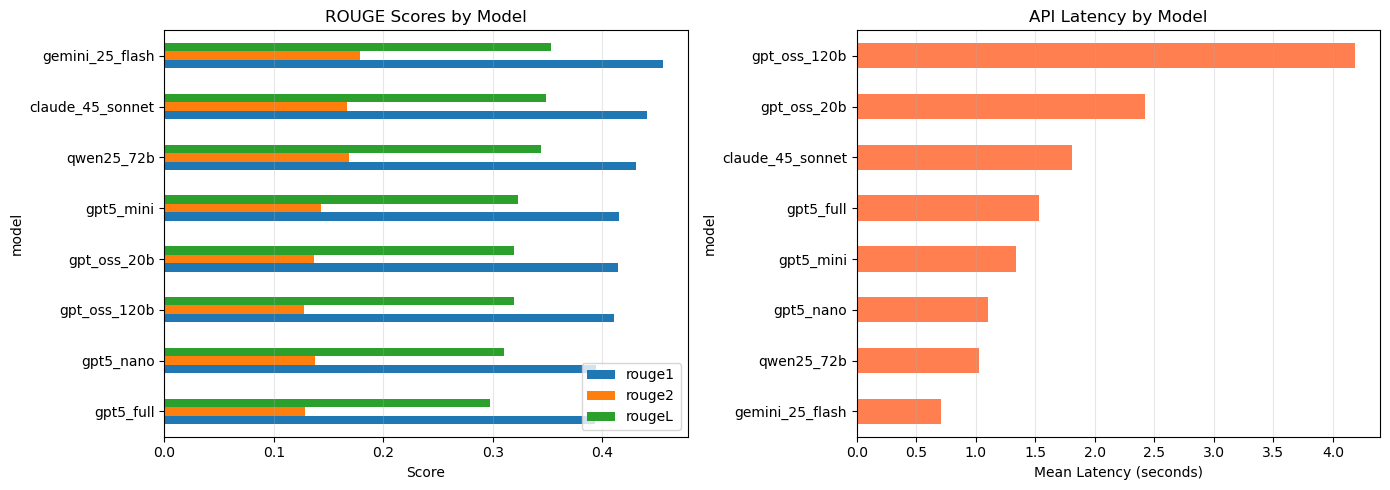

Saved figure to: /home/timnevits/projects/flatiron-language-models-for-ai/experiments/exp3_api_llm_results/rouge_latency_comparison.png


In [66]:
if rouge_df is not None and len(rouge_df) > 0:
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # ROUGE scores bar chart
    ax = axes[0]
    rouge_plot_df = rouge_df[["rouge1", "rouge2", "rougeL"]].sort_values("rougeL", ascending=True)
    rouge_plot_df.plot(kind="barh", ax=ax)
    ax.set_xlabel("Score")
    ax.set_title("ROUGE Scores by Model")
    ax.legend(loc="lower right")
    ax.grid(True, alpha=0.3, axis="x")
    
    # Latency bar chart
    ax = axes[1]
    if latency_df is not None and len(latency_df) > 0:
        latency_plot = latency_df["mean"].sort_values(ascending=True)
        latency_plot.plot(kind="barh", ax=ax, color="coral")
        ax.set_xlabel("Mean Latency (seconds)")
        ax.set_title("API Latency by Model")
        ax.grid(True, alpha=0.3, axis="x")
    else:
        ax.text(0.5, 0.5, "No latency data", ha="center", va="center", transform=ax.transAxes)
        ax.set_title("API Latency by Model")
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / "rouge_latency_comparison.png", dpi=150, bbox_inches="tight")
    plt.show()
    
    print(f"Saved figure to: {RESULTS_DIR / 'rouge_latency_comparison.png'}")


## 9. Qualitative Examples

In [67]:
heading("Qualitative Examples")

def show_examples(df, model_label, n=5, max_chars=600):
    """Show n random examples from a model's results."""
    # Filter out errors
    valid_df = df[~df["model_summary"].str.startswith(ERROR_PREFIX)]
    
    if len(valid_df) == 0:
        print(f"No valid examples for {model_label}")
        return
    
    sample = valid_df.sample(n=min(n, len(valid_df)), random_state=SEED)
    
    print(f"\n{'='*60}")
    print(f"Examples for: {model_label}")
    print(f"{'='*60}")
    
    for _, row in sample.iterrows():
        d = row["dialogue"]
        d = d[:max_chars] + " ... [truncated]" if len(d) > max_chars else d
        
        print("\n--- Example ---")
        print(f"[DIALOGUE]\n{d}")
        print(f"\n[HUMAN SUMMARY]\n{row['reference_summary']}")
        print(f"\n[MODEL SUMMARY]\n{row['model_summary']}")
        print("-" * 40)


# Show examples for each model
for label, df in results_by_model.items():
    show_examples(df, label, n=3)


Qualitative Examples

Examples for: gpt5_nano

--- Example ---
[DIALOGUE]
Jamilla: remember that the audition starts at 7.30 P.M.
Kiki: which station?
Jamilla: Antena 3
Yoyo: roger that

[HUMAN SUMMARY]
The audition starts at 7.30 P.M. in Antena 3.

[MODEL SUMMARY]
Jamilla reminds everyone the audition starts at 7:30 PM on Antena 3; Yoyo confirms with “roger that.”
----------------------------------------

--- Example ---
[DIALOGUE]
Stewart: Can you believe he even said that about the forests? Raking? Really?
Shari: Yes. I can believe that this is an ignorant man. He proves it daily. This just one more example!
Stewart: He just has no clue.
Shari: I mean, there are so many people dead and all he can think to do is criticize the forestry department? With a totally inappropriate suggestion? Puhleeze.
Stewart: I can't wait to vote for anyone else but him.
Shari: I know what you mean. Half my friends voted for him just to see what would happen! Well, guess what?
Stewart: Yeah, but we coul

## 10. Side-by-Side Model Comparison

In [68]:
heading("Side-by-Side Comparison (Same Examples)")

# Check we have enough models to compare
if len(results_by_model) < 2:
    print("Need at least 2 models for side-by-side comparison.")
    print(f"Currently have: {len(results_by_model)} model(s)")
else:
    # Get dialogues from each model
    dialogue_sets = {
        label: set(df["dialogue"].tolist()) 
        for label, df in results_by_model.items()
    }
    
    # Safely compute intersection
    all_dialogue_sets = list(dialogue_sets.values())
    if len(all_dialogue_sets) == 0:
        print("❌ No dialogue sets to compare!")
        common_dialogues = set()
    elif len(all_dialogue_sets) == 1:
        common_dialogues = all_dialogue_sets[0]
    else:
        # Start with first set, intersect with all others
        common_dialogues = all_dialogue_sets[0].copy()
        for other_set in all_dialogue_sets[1:]:
            common_dialogues &= other_set  # Same as intersection
    
    if len(common_dialogues) == 0:
        print("❌ No common dialogues found across all models!")
        print("   This can happen if models were evaluated on different samples.")
        print("\n   Dialogues per model:")
        for label, dialogues in dialogue_sets.items():
            print(f"     {label}: {len(dialogues)} dialogues")
    else:
        print(f"Found {len(common_dialogues)} dialogues common to all {len(results_by_model)} models.")
        
        # Sample from common dialogues only
        common_list = list(common_dialogues)
        n_examples = min(3, len(common_list))
        
        # Use numpy for reproducible sampling from a list
        rng = np.random.default_rng(SEED)
        sample_indices = rng.choice(len(common_list), size=n_examples, replace=False)
        sample_dialogues = [common_list[i] for i in sample_indices]
        
        # Get references from the first model's dataframe
        first_model = list(results_by_model.keys())[0]
        first_df = results_by_model[first_model]
        
        for i, dialogue in enumerate(sample_dialogues):
            # Get reference from first model's data
            ref_row = first_df[first_df["dialogue"] == dialogue].iloc[0]
            reference = ref_row["reference_summary"]
            
            print(f"\n{'='*70}")
            print(f"EXAMPLE {i+1}")
            print(f"{'='*70}")
            
            print(f"\n[DIALOGUE]\n{dialogue[:500]}{'...' if len(dialogue) > 500 else ''}")
            print(f"\n[HUMAN SUMMARY]\n{reference}")
            print(f"\n[MODEL SUMMARIES]")
            
            # Show each model's summary for this dialogue
            for label, df in results_by_model.items():
                matching_rows = df[df["dialogue"] == dialogue]
                
                if len(matching_rows) > 0:
                    model_summary = matching_rows.iloc[0]["model_summary"]
                    # Truncate long summaries for display
                    if len(model_summary) > 200:
                        model_summary = model_summary[:200] + "..."
                    print(f"  {label:20s}: {model_summary}")
                else:
                    # This shouldn't happen now, but keep as safety
                    print(f"  {label:20s}: [NOT FOUND]")
            
            print("-" * 70)


Side-by-Side Comparison (Same Examples)
Found 100 dialogues common to all 8 models.

EXAMPLE 1

[DIALOGUE]
Mom: Hi, Betty, how are you?
Betty: Hi, everything's fine and you?
Mom: me too
Mom: You could call Grandpa from time to time, you know
Mom: He's always asking about you.
Betty: I know, Mom, it's just I've been so busy.
Mom: we're all busy. You don't have to talk long, just check in.
Betty: OK, I will.
Betty: ;*

[HUMAN SUMMARY]
Mom wants Betty to call the grandfather from time to time.

[MODEL SUMMARIES]
  gpt5_nano           : Betty agrees to call Grandpa more often after her mom encourages staying in touch despite being busy. The mom emphasizes keeping in touch; Betty commits to checking in.
  gpt5_mini           : Betty tells her mom she's been busy, and her mom asks her to call Grandpa occasionally to check in; Betty agrees to do so.
  gpt5_full           : Mom reminds Betty to call Grandpa because he asks about her; Betty agrees to check in despite being busy.
  gpt_oss_20b 

## 11. Error Analysis

In [69]:
heading("Error Analysis")

error_summary = []

for label, df in results_by_model.items():
    total = len(df)
    errors = df["model_summary"].str.startswith(ERROR_PREFIX).sum()
    error_rate = errors / total * 100 if total > 0 else 0
    
    error_summary.append({
        "model": label,
        "total_requests": total,
        "errors": errors,
        "error_rate_pct": f"{error_rate:.1f}%",
    })
    
    # Show sample errors if any
    if errors > 0:
        error_samples = df[df["model_summary"].str.startswith(ERROR_PREFIX)]["model_summary"].head(2).tolist()
        print(f"{label}: {errors} errors ({error_rate:.1f}%)")
        for err in error_samples:
            print(f"  - {err[:100]}...")

error_df = pd.DataFrame(error_summary)
display(error_df)


Error Analysis
gpt_oss_20b: 1 errors (1.0%)
  - [__OPENROUTER_ERROR_7f3d2a1b__: EMPTY_RESPONSE]...
gpt_oss_120b: 6 errors (6.0%)
  - [__OPENROUTER_ERROR_7f3d2a1b__: MALFORMED_RESPONSE: No choices in response: {'error': {'message': 'I...
  - [__OPENROUTER_ERROR_7f3d2a1b__: MALFORMED_RESPONSE: No choices in response: {'error': {'message': 'I...


,model,total_requests,errors,error_rate_pct
0,gpt5_nano,100,0,0.0%
1,gpt5_mini,100,0,0.0%
2,gpt5_full,100,0,0.0%
3,gpt_oss_20b,100,1,1.0%
4,gpt_oss_120b,100,6,6.0%
5,gemini_25_flash,100,0,0.0%
6,claude_45_sonnet,100,0,0.0%
7,qwen25_72b,100,0,0.0%


## 12. Summary Table

In [ ]:
heading("Final Summary")

if rouge_df is not None and latency_df is not None:
    # Combine ROUGE and latency into one summary
    summary_data = []
    _df["n_samples"].min()
    max_samples = rouge_df["n_samples"].max()
    samples_vary = min_samples != max_samples
    
    for model in rouge_df.index:
        row = {
            "Model": model,
            "N": int(rouge_df.loc[model, "n_samples"]),
            "ROUGE-1": f"{rouge_df.loc[model, 'rouge1']:.3f}",
            "ROUGE-2": f"{rouge_df.loc[model, 'rouge2']:.3f}",
            "ROUGE-L": f"{rouge_df.loc[model, 'rougeL']:.3f}",
        }
        
        if model in latency_df.index:
            row["Mean Latency (s)"] = f"{latency_df.loc[model, 'mean']:.2f}"
            row["P95 Latency (s)"] = f"{latency_df.loc[model, 'p95']:.2f}"
        else:
            row["Mean Latency (s)"] = "N/A"
            row["P95 Latency (s)"] = "N/A"
        
        summary_data.append(row)
    
    final_summary_df = pd.DataFrame(summary_data)
    
    # =========================================================================
    # Only sort and present rankings if samples are comparable
    # =========================================================================
    if samples_vary:
        print("⚠️  WARNING: Models were evaluated on different sample sizes!")
        print(f"   Sample counts range from {min_samples} to {max_samples}.")
        print("   ROUGE scores may NOT be directly comparable.")
        print("   Models with fewer samples had more API errors.\n")
        print("   Showing results sorted by model name (NOT by score):\n")
        final_summary_df = final_summary_df.sort_values("Model")
    else:
        print(f"✓ All models evaluated on {max_samples} samples. Rankings are valid.\n")
        final_summary_df = final_summary_df.sort_values("ROUGE-L", ascending=False)
    
    final_summary_df = final_summary_df.reset_index(drop=True)
    
    # Save final summary
    final_summary_path = RESULTS_DIR / "final_summary.csv"
    final_summary_df.to_csv(final_summary_path, index=False)
    print(f"Saved final summary to: {final_summary_path}")
    
    display(final_summary_df)
    
    # =========================================================================
    # NEW: Save metadata about this evaluation run
    # This helps notebook 05 know which split was used
    # =========================================================================
    
    eval_metadata = {
        "split_used": split_name,
        "n_samples": len(eval_df),
        "seed": SEED,
        "timestamp": pd.Timestamp.now().isoformat(),
    }
    
    metadata_path = RESULTS_DIR / "evaluation_metadata.json"
    with open(metadata_path, 'w') as f:
        json.dump(eval_metadata, f, indent=2)
    print(f"Saved evaluation metadata to: {metadata_path}")
    
else:
    print("Insufficient data for final summary.")



Final Summary
⚠️  WARNING: Models were evaluated on different sample sizes!
   Sample counts range from 94 to 100.
   ROUGE scores may NOT be directly comparable.
   Models with fewer samples had more API errors.

   Showing results sorted by model name (NOT by score):

Saved final summary to: /home/timnevits/projects/flatiron-language-models-for-ai/experiments/exp3_api_llm_results/final_summary.csv


,Model,N,ROUGE-1,ROUGE-2,ROUGE-L,Mean Latency (s),P95 Latency (s)
0,claude_45_sonnet,100,0.441,0.167,0.348,1.81,2.27
1,gemini_25_flash,100,0.455,0.178,0.353,0.71,1.06
2,gpt5_full,100,0.394,0.129,0.297,1.53,2.16
3,gpt5_mini,100,0.415,0.144,0.323,1.34,1.78
4,gpt5_nano,100,0.395,0.138,0.311,1.11,1.74
5,gpt_oss_120b,94,0.411,0.128,0.319,4.19,14.62
6,gpt_oss_20b,99,0.414,0.137,0.320,2.42,6.17
7,qwen25_72b,100,0.431,0.169,0.344,1.03,1.61


Saved evaluation metadata to: /home/timnevits/projects/flatiron-language-models-for-ai/experiments/exp3_api_llm_results/evaluation_metadata.json


---
# 13. Key Takeaways — Experiment 3 (Frontier LLMs via OpenRouter)
---

*Fill this in after running:*

**ROUGE Performance:**
- Best performing model: [TBD]
- Worst performing model: [TBD]
- Score range: [TBD]

**Latency:**
- Fastest model: [TBD]
- Slowest model: [TBD]
- Latency range: [TBD]

**Quality Observations:**
- Style differences (concise vs narrative): [TBD]
- Error cases or hallucinations: [TBD]
- Which model follows instructions best: [TBD]

**Cost/Latency Trade-offs:**
- Best value (quality/latency ratio): [TBD]
- Comparison to local fine-tuned models: [TBD]

**Recommendation for Final Comparison:**
- Model to use as "frontier baseline": [TBD]
- Reasoning: [TBD]

---